# Example for calculating the overlap of two histograms

## First we create two samples of random numbers coming from a certain distribution

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

#Importing essentials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error


We will define 2 random samples coming from 2 different distributions and with different sample size

In [2]:
sample_1 = np.random.normal(34,8, 1000)
sample_2 = np.random.chisquare(50,500)

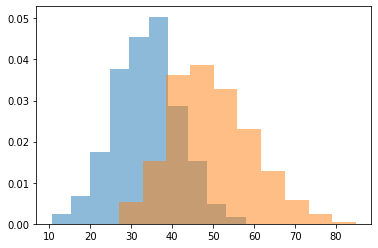

In [3]:
plt.hist(sample_1, alpha=0.5, density=True)
plt.hist(sample_2, alpha=0.5, density=True)
plt.show()

Our goal will be to come up with a measure of how much does this two distributions overlap

## Creating probability densitiy functions

We can use KDE's (Kernel Density Estimate) to get a function that approximates the probability distribtution function of each histogram

In [4]:
pdf_1 = stats.gaussian_kde(sample_1)
pdf_2 = stats.gaussian_kde(sample_2)

`pdf_1` and `pdf_2` are **functions** that can be evaluated at any point

In [5]:
print(pdf_1(4.5), pdf_1(40.0), pdf_2(62.3))

[3.39203363e-06] [0.03629275] [0.01806617]


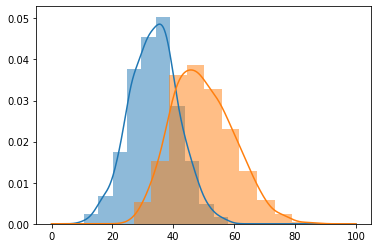

In [6]:
x = np.linspace(0, 100, 1000)
plt.hist(sample_1, alpha=0.5, density=True)
plt.hist(sample_2, alpha=0.5, density=True)
plt.plot(x, pdf_1(x), color='C0')
plt.plot(x, pdf_2(x), color='C1')
plt.show()

Now that `pdf_1` and `pdf_2` are functions we can integrate them with `scipy.integrate.quad`

In [7]:
import scipy.integrate as integrate

In [8]:
result = integrate.quad(lambda x: pdf_1(x),  -np.inf,  np.inf)
print(result[0])
result = integrate.quad(lambda x: pdf_2(x),  -np.inf,  np.inf)
print(result[0])

1.0000000000000002
0.999999999999999


These functions generated by `scipy.stats.gaussian_kde` are already normilized so that
$$ \int f_{\rm kde} (x) dx = 1.$$

However, so that we can measure an overlap we need to normalize the **square** of the function (the way it is done for wavefunctions in quantum mechanics) so that
$$ \int f^2_{\rm kde} (x) dx = 1.$$

Now we can define the overlap as
$$ \int f_{\rm kde} (x) g_{\rm kde} (x) dx$$

## Defining function that calculates the overlap of two functions

In [9]:
def overlap(f1, f2):
    # First we need to calaculate the normalization constants
    n1 = integrate.quad(lambda x: f1(x)**2,  -np.inf,  np.inf)[0]
    n2 = integrate.quad(lambda x: f2(x)**2,  -np.inf,  np.inf)[0]
    # Normalizing these functions (the quantum mechanis way) means doing the replacement f(x) -> f(x)/sqrt(N)
    # So we calculate the integral of the product and divide by sqrt(N1*N2)
    return integrate.quad(lambda x: f1(x)*f2(x),  -np.inf,  np.inf)[0]/np.sqrt(n1*n2)

### Testing the function by calculating the overlap of a function with itself

In [10]:
print(overlap(pdf_1, pdf_1))
print(overlap(pdf_2, pdf_2))

1.0
1.0


### Calculating the overlap of our two kde approximated functions

In [11]:
print(overlap(pdf_1, pdf_2))

0.5061209145716757


### Making sure that our new overlap operator commutes

In [12]:
print(overlap(pdf_2, pdf_1))

0.5061209145716757


## Based on our current examples we can define a function that takes two samples and calculates their overlaps

In [13]:
def sample_overlap(x1, x2):
    # x1 is a numpy array representing the first sample
    # x2 is a numpy array representing the second sample
    pdf1 = stats.gaussian_kde(x1)
    pdf2 = stats.gaussian_kde(x2)
    # We rely on the overlap function we defined earlier
    return overlap(pdf1, pdf2)

Just to confirm that our new function works we test it with the samples we already created and compare results

In [14]:
# Here we are using the function that takes functions as arguments
print(overlap(pdf_2, pdf_1))
# Here we are using the function that takes samples as arguments
print( sample_overlap(sample_1, sample_2))

0.5061209145716757
0.5061209145716757


## For convinience lets also define a function that plots 2 samples and their KDE's

In [15]:
def samples_hist_kde_plot(x1, x2, name1, name2, x_axis_name):
    #Finding the minimum and maximum among all elements in both samples
    x_min = min(np.amin(x1), np.amin(x2))
    x_max = max(np.amax(x1), np.amax(x2))
    # Shifting the minimum a little bit to the left
    x_min -= np.abs(x_min)*.1
    # Shifting the maximum a little bit to the right
    x_max += np.abs(x_max)*.1
    # Using those min and max to create an array where the KDE's will be evaluated for plotting
    x = np.linspace(x_min, x_max, 1000)
    pdf1 = stats.gaussian_kde(x1)
    pdf2 = stats.gaussian_kde(x2)
    plt.hist(x1, alpha=0.5, density=True)
    plt.hist(x2, alpha=0.5, density=True)
    plt.plot(x, pdf1(x), color='C0', label = name1)
    plt.plot(x, pdf2(x), color='C1', label = name2)
    plt.xlabel(x_axis_name)
    plt.legend()
    plt.show()

Testing with our current samples

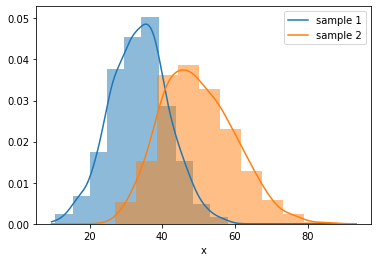

In [16]:
samples_hist_kde_plot(sample_1, sample_2, 'sample 1', 'sample 2', 'x')

## Now we can try other sampes
## Two samples from gaussian distributions that do not overlap

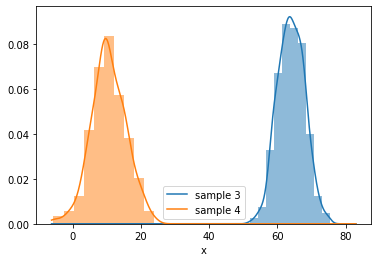

Samples overlap is: 3.062619051089687e-125


In [17]:
sample_3 = np.random.normal(64,4, 1000)
sample_4 = np.random.normal(10,5, 300)
#Notice the different sample sizes
samples_hist_kde_plot(sample_3, sample_4, 'sample 3', 'sample 4', 'x')
print('Samples overlap is: {}'.format(sample_overlap(sample_3, sample_4)))

## Two samples from gaussian distributions that mostly overlap

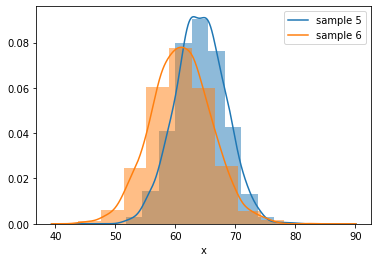

Samples overlap is: 0.8785851226242363


In [18]:
sample_5 = np.random.normal(64,4, 1000)
sample_6 = np.random.normal(61,5, 3000)
#Notice the different sample sizes
samples_hist_kde_plot(sample_5, sample_6, 'sample 5', 'sample 6', 'x')
print('Samples overlap is: {}'.format(sample_overlap(sample_5, sample_6)))

## Final note
This is different from the other measure we discussed that calculates the area under where both functions overlap. But that could in principle be defined in a similar fashion. However the the normalization constant and the overlap integral would have to be defined differently.

In fact, here the functions are already normizalized. All that would have to be different is the overlap integral. Not taking the product but the minimum of both fucntions at every value of x

# Testing these new overlap functions with new mass tables

## Reading files with experimental values and calculated values

We are going to read the data files as pandas dataframes

In [19]:
import pandas as pd

`csv` stands for comma separated file. Our datafile with the experimental is not really in `csv` format, but we can use a a regular expression to say that the separator is an arbitrary number of spaces `\s+` instead of a comma.

We will also rename some columns to use the same names as the theory dataframe. That will make finding intersections easier.

In [20]:
exp_energies = pd.read_csv('EXPERIMENT_AME2016_headers.dat', sep='\s+')
exp_energies = exp_energies.rename(columns={'Z': 'proton_number', 'N': 'neutron_number', \
                                             'E': 'exp_energy', \
                                             'E/A': 'exp_energy_per_nucleons'})

pandas data frames can be displayed in jupyter notebooks by simply executing a cell with the dataframe's name

In [21]:
exp_energies

,Num,Nuc,A,neutron_number,proton_number,exp_energy,exp_energy_per_nucleons,dE,Eval,S1n,...,Eval.1,S1p,dS1p,Eval.2,S2n,dS2n,Eval.3,S2p,dS2p,Eval.4
0,1,H,2,1,1,-2.224552,-1.112276,0.000000,0,0.000000,...,0,0.000000,0.000,0,0.000000,0.000000,0,0.000000,0.000,0
1,2,H,3,2,1,-8.481781,-2.827260,0.000000,0,6.257229,...,0,0.000000,0.000,0,0.000000,0.000000,0,0.000000,0.000,0
2,3,H,4,3,1,-6.881782,-1.720445,0.100000,0,-1.599999,...,0,0.000000,0.000,0,4.657230,0.100000,0,0.000000,0.000,0
3,4,H,5,4,1,-6.681781,-1.336356,0.089445,0,-0.200001,...,0,0.000000,0.000,0,-1.800000,0.089445,0,0.000000,0.000,0
4,5,H,6,5,1,-5.769820,-0.961637,0.254124,0,-0.911961,...,0,0.000000,0.000,0,-1.111962,0.354124,0,0.000000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3428,3429,Ts,293,176,117,-2077.388399,-7.090063,0.879000,1,7.095000,...,2,0.929189,1.755,2,13.317000,1.461000,2,3.937983,1.752,2
3429,3430,Ts,294,177,117,-2083.601399,-7.087080,0.588000,1,6.213000,...,2,1.491189,1.174,2,13.308000,1.172000,2,0.000000,0.000,0
3430,3431,Og,293,175,118,-2072.079974,-7.071945,0.586000,1,0.000000,...,0,1.786575,1.170,2,0.000000,0.000000,0,2.736764,1.168,2
3431,3432,Og,294,176,118,-2079.744974,-7.073962,0.588000,1,7.665000,...,2,2.356575,1.467,2,0.000000,0.000000,0,3.285764,1.464,2


Now we can read a mass table of calculated nuclei with a whole bunch of different properties

In [53]:
theory = pd.read_csv('ground_states_une0_quartz_intel_mkl-omp.csv')
theory_only = theory[pd.merge(theory, exp_match, on=['proton_number','neutron_number'], how='left', indicator=True)['_merge'] == 'left_only']

Now lets plot both nuclear landscape to see where they match and where they don't

In [23]:
def compare_two_charts(chart1, chart2):
    # chart1 is a pandas dataframe
    # chart2 is a pandas dataframe
    # both charts have to have columns named 'neutron_number' and 'proton_number'
    fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
    #plt.scatter(chart1['neutron_number'], chart1['proton_number'], c='C0', s=16)
    plt.scatter(chart2['neutron_number'], chart2['proton_number'], c='C1', s=8)
    plt.show()

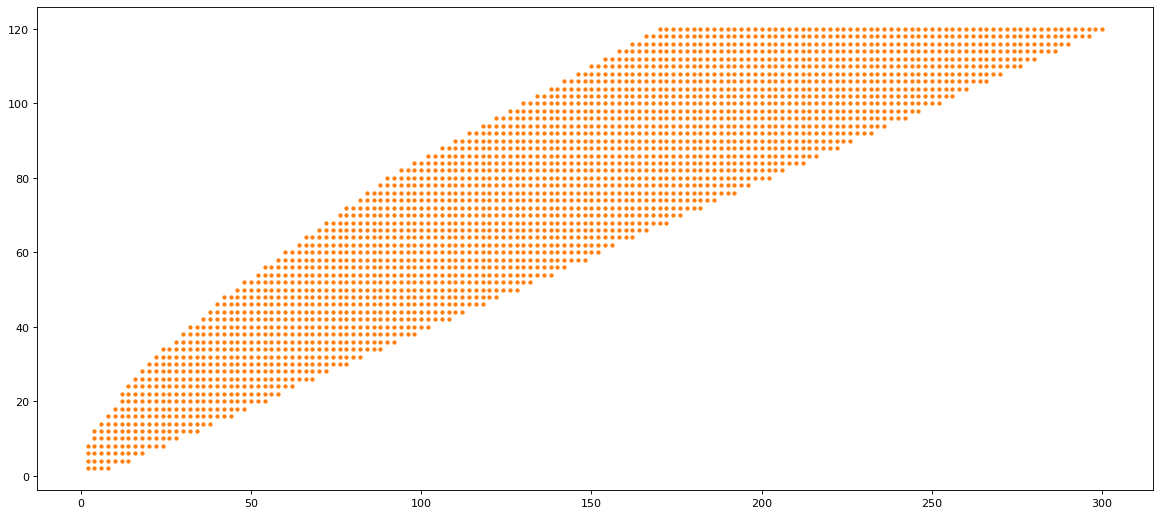

In [24]:
compare_two_charts(exp_energies, theory)

## Creating two dataframes.

### One for the nuclei that match

In [54]:
def intersect(chart1, chart2):
    return pd.merge(chart1, chart2, how='inner', on=['proton_number', 'neutron_number'])



In [55]:
exp_match = intersect(exp_energies, theory)
#exp_match['energy']
#exp_match['exp_energy']
exp_match_diff=exp_match['energy']-exp_match['exp_energy']
exp_match_diff

exp_match['exp_theory_diff']=exp_match_diff

### and one for those that are only in the theory set

Now we can compare the distribution of different DFT properties for the nuclei that have an experimental match and those who don't using the functions we defined previously

In [56]:
def compare_two_properties(chart1, chart2, column, name1, name2):
    overlap = sample_overlap(chart1[column], theory_only[column])
    print(column+' overlap is: {}'.format(overlap))
    samples_hist_kde_plot(chart1[column], chart2[column], name1, name2, column)
    return overlap





In [57]:
column_names=[]
for i in range(0,len(exp_match.columns)):
    if (exp_match.columns[i] !="converged") and (exp_match.columns[i] != "dipole-moment_n") and (exp_match.columns[i] != "dipole-moment_p") and (exp_match.columns[i] != "dipole-moment_t") and (exp_match.columns[i] !="octupole-moment_n") and (exp_match.columns[i] !="octupole-moment_p") and (exp_match.columns[i] !="octupole-moment_t") and (exp_match.columns[i] !="q5-moment_n") and (exp_match.columns[i] !="q5-moment_p") and (exp_match.columns[i] !="q5-moment_t") and (exp_match.columns[i] !="q7-moment_n") and (exp_match.columns[i] !="q7-moment_p") and (exp_match.columns[i] !="q7-moment_t") and (exp_match.columns[i] !="(Nabla-rho)^2-energy") and (exp_match.columns[i] !="Nabla-rho-J-energy") and (exp_match.columns[i] !="pairing-coulomb") and (exp_match.columns[i] !="tensor-energy") and (exp_match.columns[i] !="direct-hartree") and (exp_match.columns[i] !="extra-energy")  and (exp_match.columns[i] !="external-field-energy")  and (exp_match.columns[i] !="entropy_n") and (exp_match.columns[i] !="entropy_p") and (exp_match.columns[i] !="entropy_t"):
        column_names.append(exp_match.columns[i])
column_names




['Num',
 'Nuc',
 'A',
 'neutron_number',
 'proton_number',
 'exp_energy',
 'exp_energy_per_nucleons',
 'dE',
 'Eval',
 'S1n',
 'dS1n',
 'Eval.1',
 'S1p',
 'dS1p',
 'Eval.2',
 'S2n',
 'dS2n',
 'Eval.3',
 'S2p',
 'dS2p',
 'Eval.4',
 'energy',
 'accuracy',
 'chemical-pot_n',
 'chemical-pot_p',
 'Fermi-level_n',
 'Fermi-level_p',
 'pairing-gap_n',
 'pairing-gap_p',
 'pairing-cutoff',
 'pairing-energy_n',
 'pairing-energy_p',
 'pairing-energy_t',
 'effective-strength-G_n',
 'effective-strength-G_p',
 'LN-chemical-pot_n',
 'LN-chemical-pot_p',
 'LN-energy_n',
 'LN-energy_p',
 'LN-energy_t',
 'rms-radius_n',
 'rms-radius_p',
 'rms-radius_t',
 'charge-radius',
 'nuclear-radius',
 'LN-rms-radius_n',
 'LN-rms-radius_p',
 'LN-rms-radius_t',
 'LN-charge-radius',
 'LN-nuclear-radius',
 'beta2-deformation_n',
 'beta2-deformation_p',
 'beta2-deformation_t',
 'LN-beta2-deformation_n',
 'LN-beta2-deformation_p',
 'LN-beta2-deformation_t',
 'quadrupole-moment_n',
 'quadrupole-moment_p',
 'quadrupole-mom

In [58]:
#exp_match
theory_only

,neutron_number,proton_number,energy,converged,accuracy,chemical-pot_n,chemical-pot_p,Fermi-level_n,Fermi-level_p,pairing-gap_n,...,direct-coulomb,exchange-coulomb,pairing-coulomb,tensor-energy,direct-hartree,extra-energy,external-field-energy,entropy_n,entropy_p,entropy_t
10,14,4,-70.533226,True,0.000006,0.466869,-28.228387,0.466869,-28.228387,0.998060,...,4.557142,-1.237890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,18,6,-123.339701,True,0.000009,0.461271,-28.207987,0.461271,-28.207987,0.661195,...,9.339524,-1.944149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,2,8,-21.855938,True,0.000003,-25.998858,2.906941,-25.998858,2.906941,1.553589,...,13.554070,-2.293766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,22,8,-171.501672,True,0.000005,0.646718,-25.654229,0.646718,-25.654229,0.747082,...,15.327600,-2.642915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,24,8,-168.636328,True,0.000009,0.924119,-26.702900,0.924119,-26.702900,0.837790,...,15.238199,-2.626781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614,292,120,-2412.464050,True,0.000008,-0.016614,-14.442701,-0.016614,-14.442701,0.511199,...,1415.437429,-42.269810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2615,294,120,-2412.321271,True,0.000009,0.050820,-14.597508,0.050820,-14.597508,0.513217,...,1413.288237,-42.211220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2616,296,120,-2412.072479,True,0.000010,0.114719,-14.750565,0.114719,-14.750565,0.517017,...,1411.191511,-42.153284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2617,298,120,-2411.714303,True,0.000007,0.178482,-14.904347,0.178482,-14.904347,0.518614,...,1409.124369,-42.095950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Num
KeyError
Nuc
KeyError
A
KeyError
neutron_number
neutron_number overlap is: 0.5229130458198699


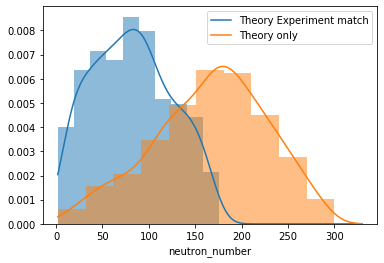

proton_number
proton_number overlap is: 0.7559866263894158


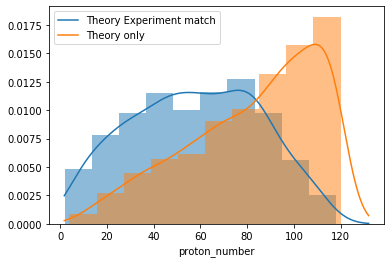

exp_energy
KeyError
exp_energy_per_nucleons
KeyError
dE
KeyError
Eval
KeyError
S1n
KeyError
dS1n
KeyError
Eval.1
KeyError
S1p
KeyError
dS1p
KeyError
Eval.2
KeyError
S2n
KeyError
dS2n
KeyError
Eval.3
KeyError
S2p
KeyError
dS2p
KeyError
Eval.4
KeyError
energy
energy overlap is: 0.6356532113369928


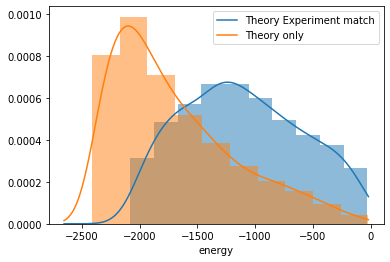

accuracy
accuracy overlap is: nan


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


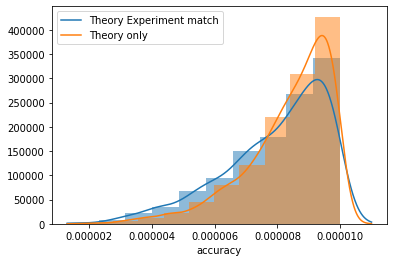

chemical-pot_n
chemical-pot_n overlap is: 0.3048480714591378


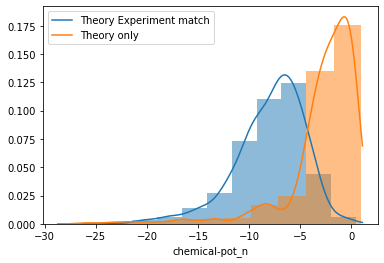

chemical-pot_p
chemical-pot_p overlap is: 0.6042906598236597


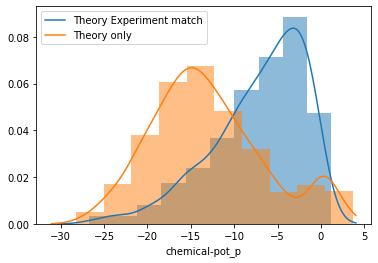

Fermi-level_n
Fermi-level_n overlap is: 0.3048480714591378


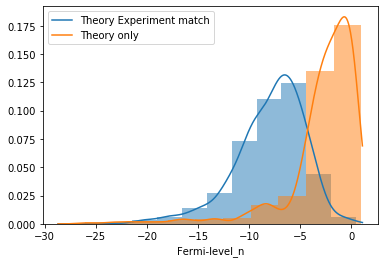

Fermi-level_p
Fermi-level_p overlap is: 0.6042906598236597


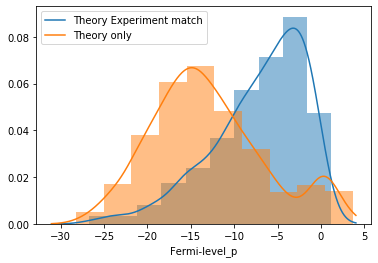

pairing-gap_n
pairing-gap_n overlap is: 0.9316857516921837


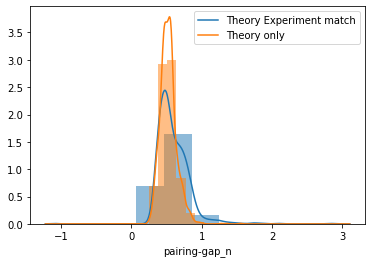

pairing-gap_p
pairing-gap_p overlap is: 0.7895655226029906


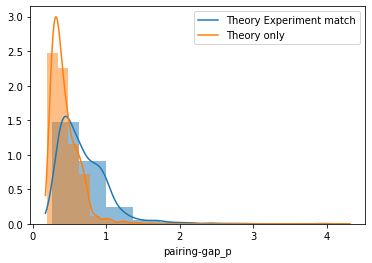

pairing-cutoff
pairing-cutoff overlap is: nan


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


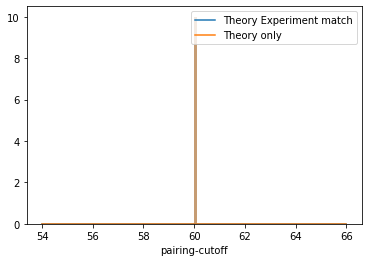

pairing-energy_n
pairing-energy_n overlap is: 0.6416939445551308


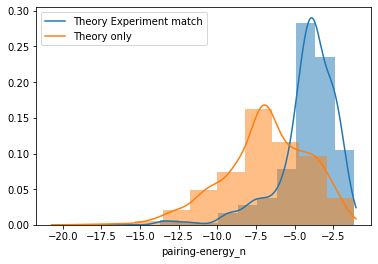

pairing-energy_p
pairing-energy_p overlap is: 0.8910776811356087


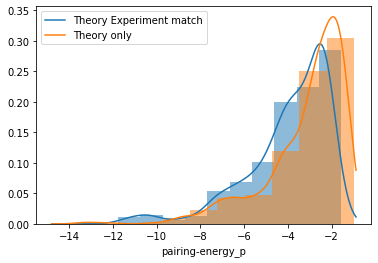

pairing-energy_t
pairing-energy_t overlap is: 0.8062843519205313


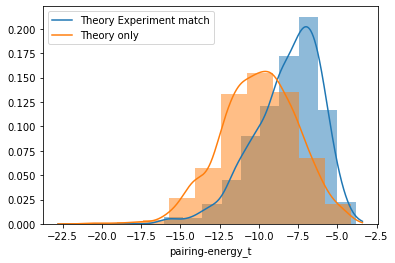

effective-strength-G_n
effective-strength-G_n overlap is: 0.702107918993245


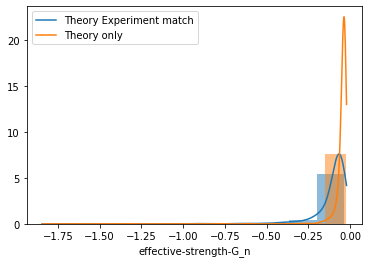

effective-strength-G_p
effective-strength-G_p overlap is: 0.708360285985923


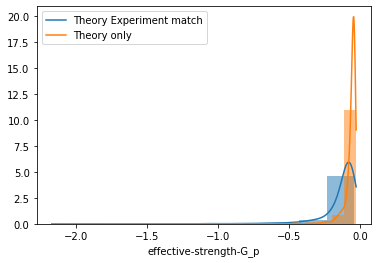

LN-chemical-pot_n
LN-chemical-pot_n overlap is: 0.7987229365186795


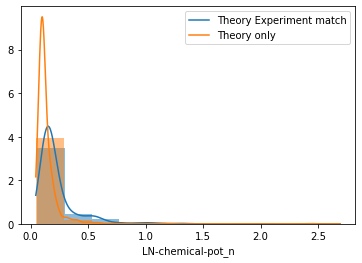

LN-chemical-pot_p
LN-chemical-pot_p overlap is: 0.8451972526302034


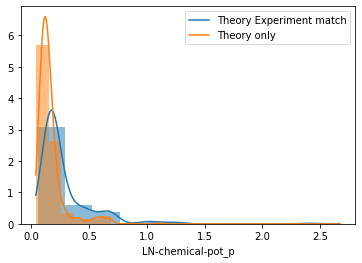

LN-energy_n
LN-energy_n overlap is: 0.9050606901364372


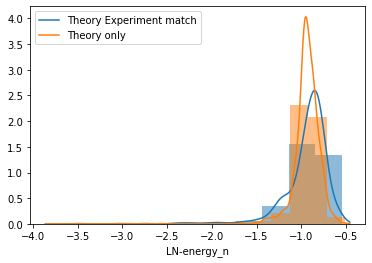

LN-energy_p
LN-energy_p overlap is: 0.6745898002621268


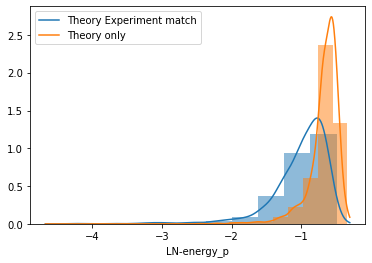

LN-energy_t
LN-energy_t overlap is: 0.8019721129796813


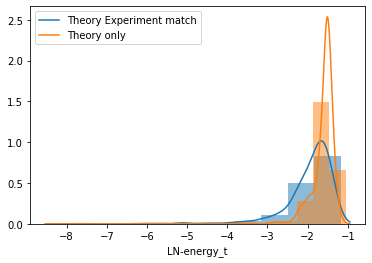

rms-radius_n
rms-radius_n overlap is: 0.5231582822986557


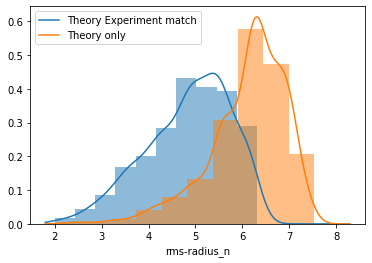

rms-radius_p
rms-radius_p overlap is: 0.6329276765799678


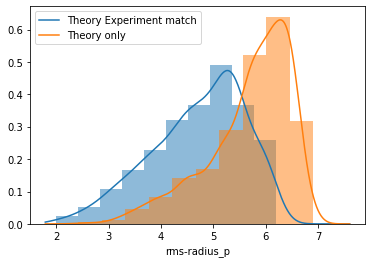

rms-radius_t
rms-radius_t overlap is: 0.5524499114166866


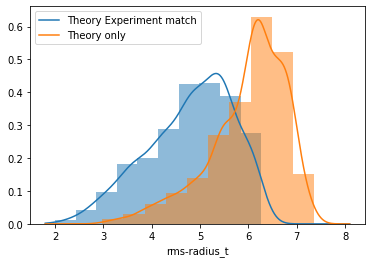

charge-radius
charge-radius overlap is: 0.6348672748312054


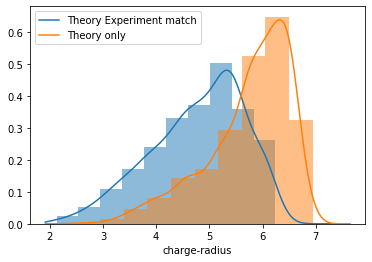

nuclear-radius
nuclear-radius overlap is: 0.5928596536303335


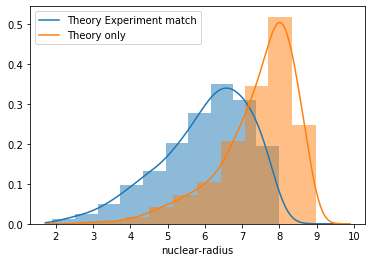

LN-rms-radius_n
LN-rms-radius_n overlap is: 0.5234403000675127


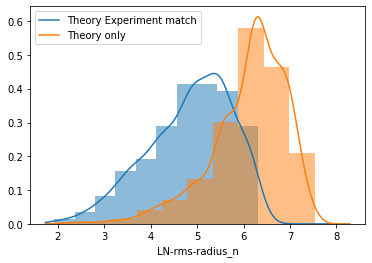

LN-rms-radius_p
LN-rms-radius_p overlap is: 0.63321140302564


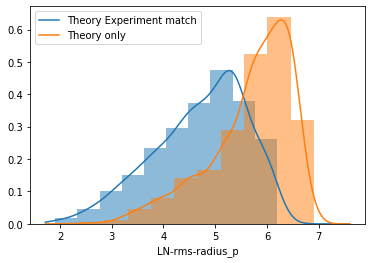

LN-rms-radius_t
LN-rms-radius_t overlap is: 0.5527716160634424


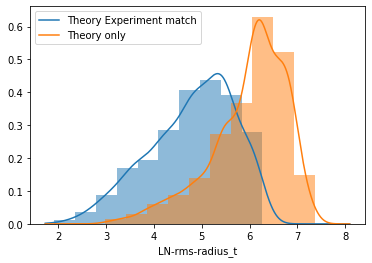

LN-charge-radius
LN-charge-radius overlap is: 0.6351427672590929


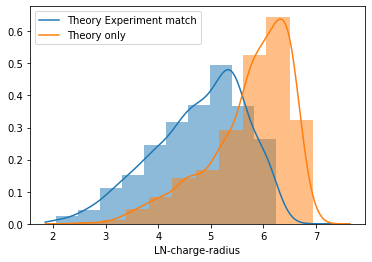

LN-nuclear-radius
LN-nuclear-radius overlap is: 0.5928596536303335


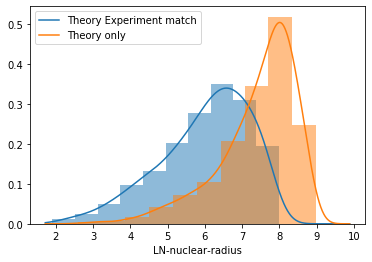

beta2-deformation_n
beta2-deformation_n overlap is: 0.9253448178076016


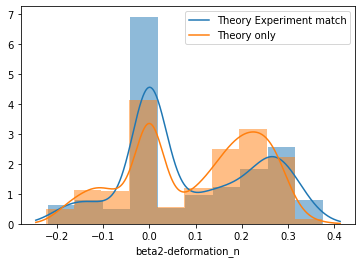

beta2-deformation_p
beta2-deformation_p overlap is: 0.9388232203753684


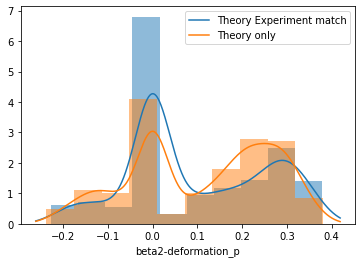

beta2-deformation_t
beta2-deformation_t overlap is: 0.9273597850350148


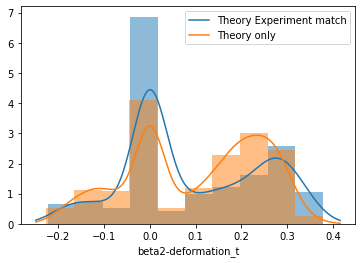

LN-beta2-deformation_n
LN-beta2-deformation_n overlap is: 0.9258671306139102


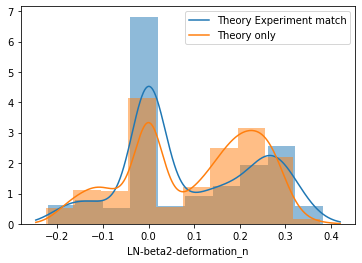

LN-beta2-deformation_p
LN-beta2-deformation_p overlap is: 0.9388044663544316


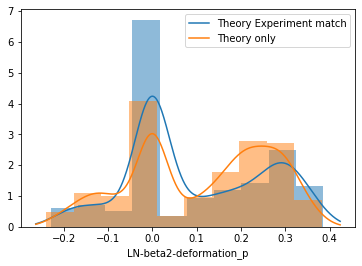

LN-beta2-deformation_t
LN-beta2-deformation_t overlap is: 0.927438679681627


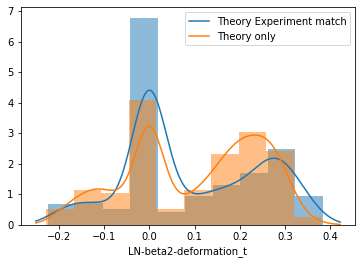

quadrupole-moment_n
quadrupole-moment_n overlap is: 0.821718290585614


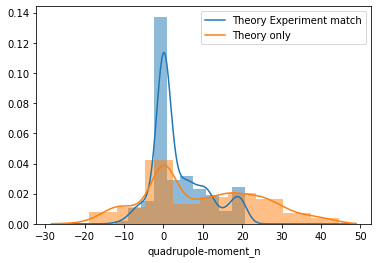

quadrupole-moment_p
quadrupole-moment_p overlap is: 0.8884431731670124


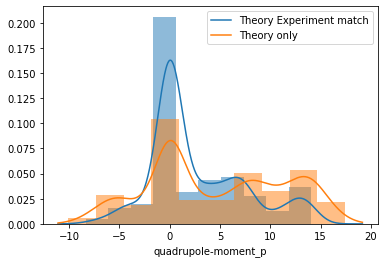

quadrupole-moment_t
quadrupole-moment_t overlap is: 0.8445510310142106


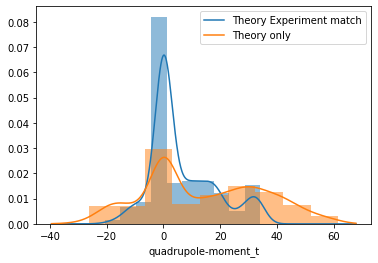

LN-quadrupole-moment_n
LN-quadrupole-moment_n overlap is: 0.8213188752277754


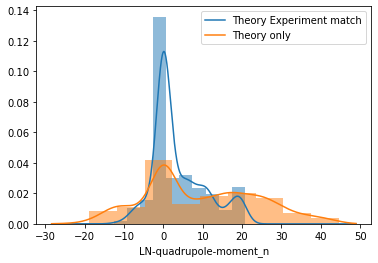

LN-quadrupole-moment_p
LN-quadrupole-moment_p overlap is: 0.8883408114931488


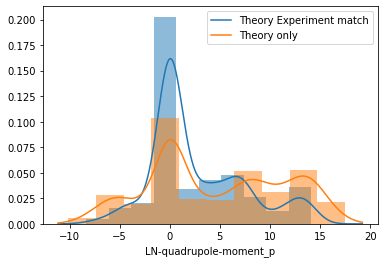

LN-quadrupole-moment_t
LN-quadrupole-moment_t overlap is: 0.844191450988674


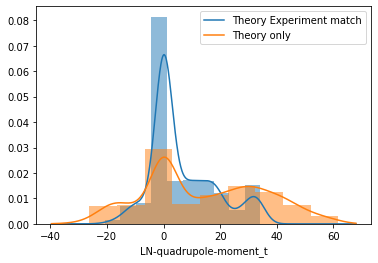

hexadecapole-moment_n
hexadecapole-moment_n overlap is: 0.838240413033117


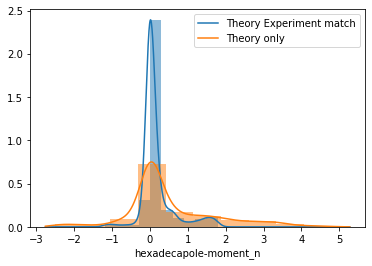

hexadecapole-moment_p
hexadecapole-moment_p overlap is: 0.951737809296979


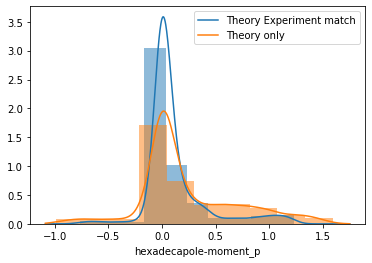

hexadecapole-moment_t
hexadecapole-moment_t overlap is: 0.8834966495630375


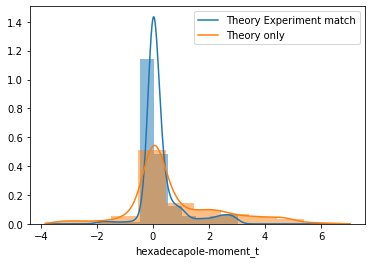

LN-hexadecapole-moment_n
LN-hexadecapole-moment_n overlap is: 0.8375773756839506


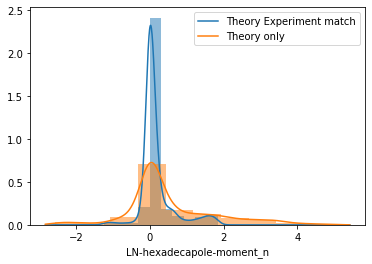

LN-hexadecapole-moment_p
LN-hexadecapole-moment_p overlap is: 0.9525069506144447


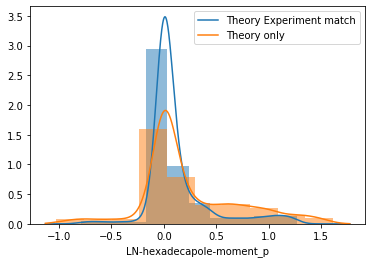

LN-hexadecapole-moment_t
LN-hexadecapole-moment_t overlap is: 0.883356870092904


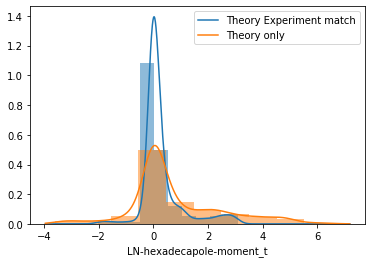

q6-moment_n
q6-moment_n overlap is: 0.7892511653164962


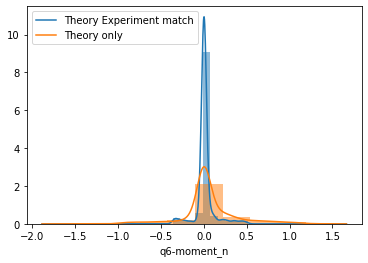

q6-moment_p
q6-moment_p overlap is: 0.9462454462544226


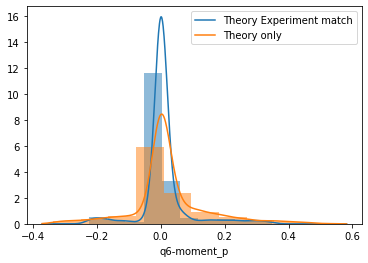

q6-moment_t
q6-moment_t overlap is: 0.8559012910028897


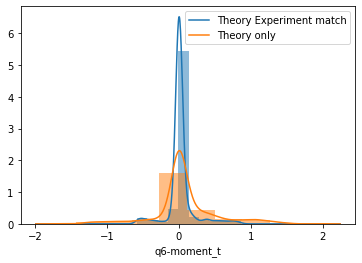

q8-moment_n
q8-moment_n overlap is: 0.5898300973449946


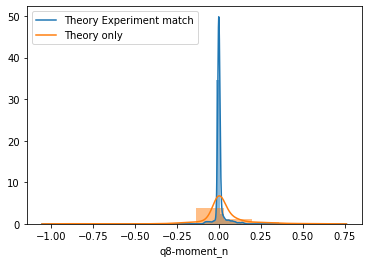

q8-moment_p
q8-moment_p overlap is: 0.9460610894594028


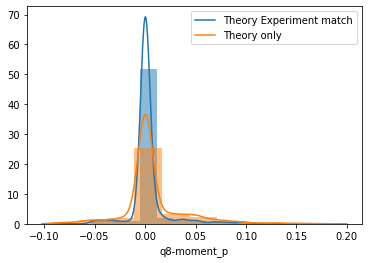

q8-moment_t
q8-moment_t overlap is: 0.7091325069723726


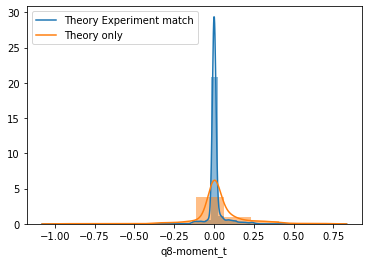

kinetic-energy_n
kinetic-energy_n overlap is: 0.5264888122574449


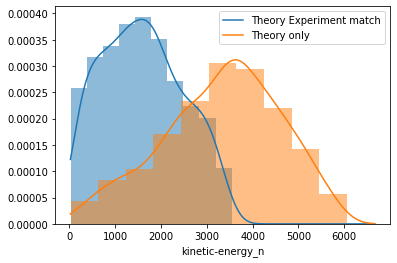

kinetic-energy_p
kinetic-energy_p overlap is: 0.8735046107438809


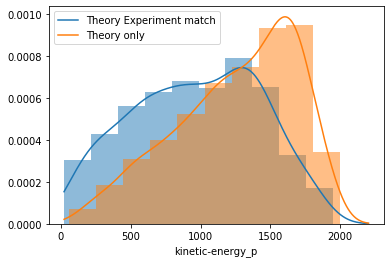

kinetic-energy_t
kinetic-energy_t overlap is: 0.5978432995339763


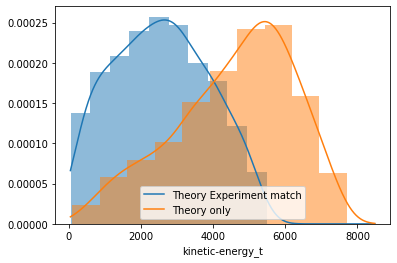

volume-energy


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  after removing the cwd from sys.path.


volume-energy overlap is: 38.830720514589


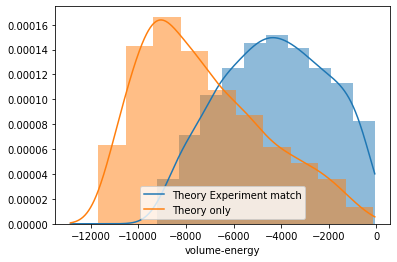

rho-tau-energy
rho-tau-energy overlap is: 0.5166740393098871


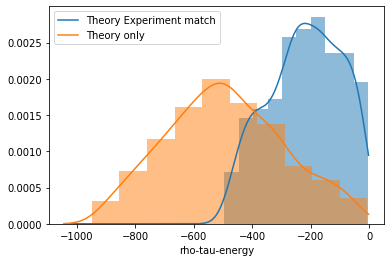

rho-rho-energy


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  after removing the cwd from sys.path.


rho-rho-energy overlap is: 40.893025978290076


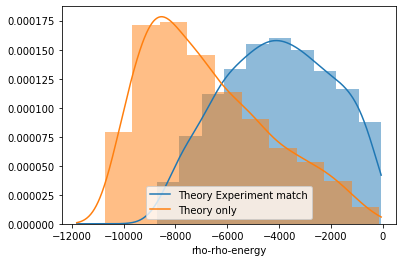

surface-energy
surface-energy overlap is: 0.7414511080411414


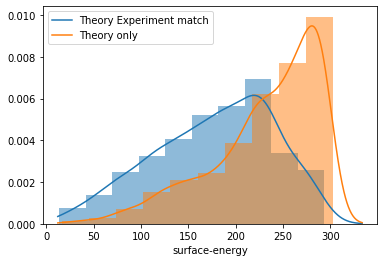

rho-Delta-rho-energy
rho-Delta-rho-energy overlap is: 0.7414511080411414


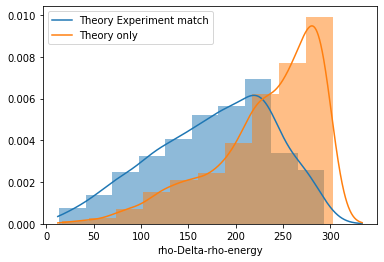

spin-orbit-energy
spin-orbit-energy overlap is: 0.8952350594503793


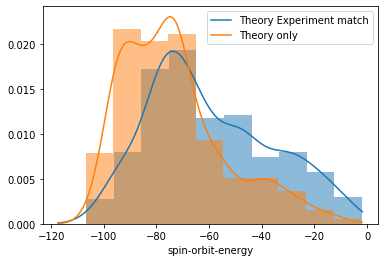

rho-Nabla-J-energy
rho-Nabla-J-energy overlap is: 0.8952350594503793


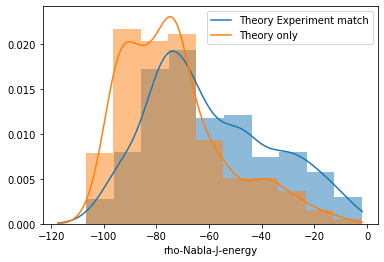

coulomb-energy
coulomb-energy overlap is: 0.7914170209538685


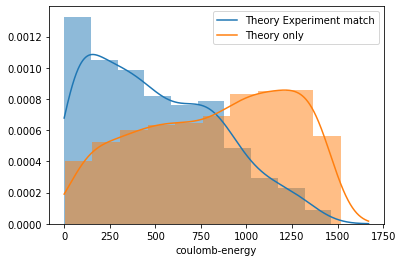

direct-coulomb
direct-coulomb overlap is: 0.7918321988860973


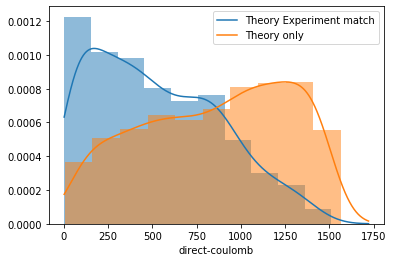

exchange-coulomb
exchange-coulomb overlap is: 0.8127498819126143


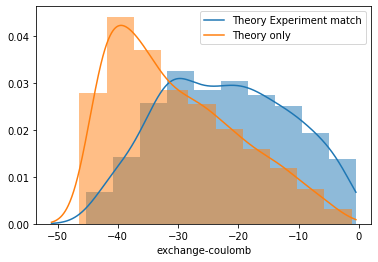

exp_theory_diff
KeyError


In [59]:
#beta2_total_overlap = compare_two_properties(exp_match,theory_only,column_names[0],'Theory Experiment match','Theory only')
overlapped=[]
for column in column_names:
    try:
        print(column)
        beta2_total_overlap = compare_two_properties(exp_match,theory_only,column,'Theory Experiment match','Theory only')
        overlapped.append((column, beta2_total_overlap))
    except KeyError:
        print("KeyError")
        continue
    
    
    

In [68]:
#np.sort(overlapped,axis=0)
overlapped

[('neutron_number', 0.5229130458198699),
 ('proton_number', 0.7559866263894158),
 ('energy', 0.6356532113369928),
 ('accuracy', nan),
 ('chemical-pot_n', 0.3048480714591378),
 ('chemical-pot_p', 0.6042906598236597),
 ('Fermi-level_n', 0.3048480714591378),
 ('Fermi-level_p', 0.6042906598236597),
 ('pairing-gap_n', 0.9316857516921837),
 ('pairing-gap_p', 0.7895655226029906),
 ('pairing-cutoff', nan),
 ('pairing-energy_n', 0.6416939445551308),
 ('pairing-energy_p', 0.8910776811356087),
 ('pairing-energy_t', 0.8062843519205313),
 ('effective-strength-G_n', 0.702107918993245),
 ('effective-strength-G_p', 0.708360285985923),
 ('LN-chemical-pot_n', 0.7987229365186795),
 ('LN-chemical-pot_p', 0.8451972526302034),
 ('LN-energy_n', 0.9050606901364372),
 ('LN-energy_p', 0.6745898002621268),
 ('LN-energy_t', 0.8019721129796813),
 ('rms-radius_n', 0.5231582822986557),
 ('rms-radius_p', 0.6329276765799678),
 ('rms-radius_t', 0.5524499114166866),
 ('charge-radius', 0.6348672748312054),
 ('nuclear-rad

direct-coulomb overlap is: 0.7918321988860973


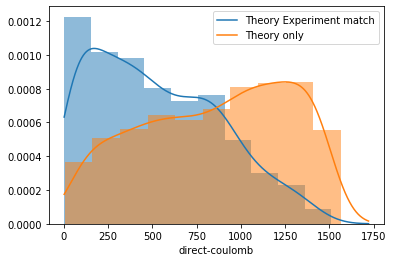

In [60]:
direct_coulomb = compare_two_properties(exp_match, theory_only, 'direct-coulomb', 'Theory Experiment match', 'Theory only')

In [61]:
#np.sort(np.transpose(overlapped)[1])

#np.sort(np.transpose(overlapped)[1])
ascending_overlap=[0.3048480714591378, 0.3048480714591378, 0.5166740393098871,
       0.5229130458198699, 0.5231582822986557, 0.5234403000675127,
       0.5264888122574449, 0.5524499114166866, 0.5527716160634424,
       0.5898300973449946, 0.5928596536303335, 0.5928596536303335,
       0.5978432995339763, 0.6042906598236597, 0.6042906598236597,
       0.6329276765799678, 0.63321140302564, 0.6348672748312054,
       0.6351427672590929, 0.6356532113369928, 0.6416939445551308,
       0.6745898002621268, 0.702107918993245, 0.708360285985923,
       0.7091325069723726, 0.7414511080411414, 0.7414511080411414,
       0.7559866263894158, 0.7892511653164962, 0.7895655226029906,
       0.7914170209538685, 0.7918321988860973, 0.7987229365186795,
       0.8019721129796813, 0.8062843519205313, 0.8127498819126143,
       0.8213188752277754, 0.821718290585614, 0.8375773756839506,
       0.838240413033117, 0.844191450988674, 0.8445510310142106,
       0.8451972526302034, 0.8559012910028897, 0.8735046107438809,
       0.883356870092904, 0.8834966495630375, 0.8883408114931488,
       0.8884431731670124, 0.8910776811356087, 0.8952350594503793,
       0.8952350594503793, 0.9050606901364372, 0.9253448178076016,
       0.9258671306139102, 0.9273597850350148, 0.927438679681627,
       0.9316857516921837, 0.9388044663544316, 0.9388232203753684,
       0.9460610894594028, 0.9462454462544226, 0.951737809296979,
       0.9525069506144447, 38.830720514589, 40.893025978290076]

top_overlap=[0.8884431731670124, 0.8910776811356087, 0.8952350594503793,0.8952350594503793, 0.9050606901364372, 0.9253448178076016,0.9258671306139102, 0.9273597850350148, 0.927438679681627,0.9316857516921837, 0.9388044663544316, 0.9388232203753684,0.9460610894594028, 0.9462454462544226, 0.951737809296979,0.9525069506144447,]




quadrupole-moment_p    0.8884431731670124
pairing-energy_p    0.8910776811356087
spin-orbit-energy    0.8952350594503793
rho-Nabla-J-energy    0.8952350594503793
spin-orbit-energy    0.8952350594503793
rho-Nabla-J-energy    0.8952350594503793
LN-energy_n    0.9050606901364372
beta2-deformation_n    0.9253448178076016
LN-beta2-deformation_n    0.9258671306139102
beta2-deformation_t    0.9273597850350148
LN-beta2-deformation_t    0.927438679681627
pairing-gap_n    0.9316857516921837
LN-beta2-deformation_p    0.9388044663544316
beta2-deformation_p    0.9388232203753684
q8-moment_p    0.9460610894594028
q6-moment_p    0.9462454462544226
hexadecapole-moment_p    0.951737809296979
LN-hexadecapole-moment_p    0.9525069506144447
quadrupole-moment_p overlap is: 0.8884431731670124


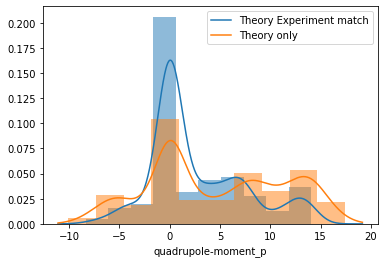

pairing-energy_p overlap is: 0.8910776811356087


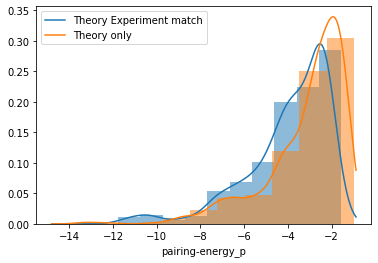

spin-orbit-energy overlap is: 0.8952350594503793


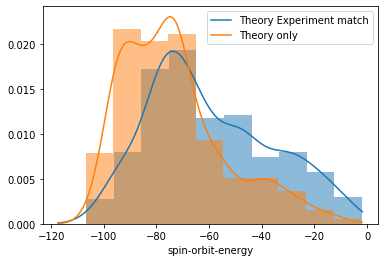

rho-Nabla-J-energy overlap is: 0.8952350594503793


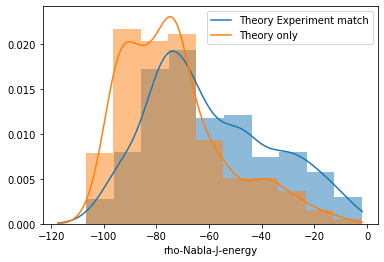

spin-orbit-energy overlap is: 0.8952350594503793


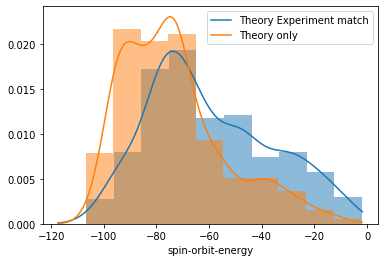

rho-Nabla-J-energy overlap is: 0.8952350594503793


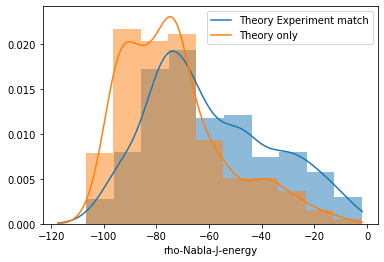

LN-energy_n overlap is: 0.9050606901364372


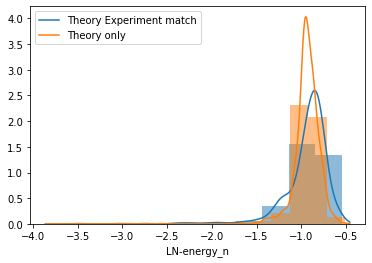

beta2-deformation_n overlap is: 0.9253448178076016


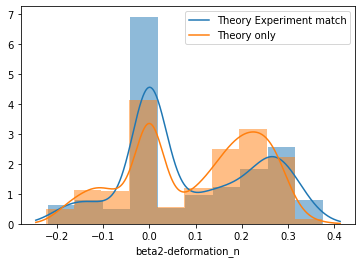

LN-beta2-deformation_n overlap is: 0.9258671306139102


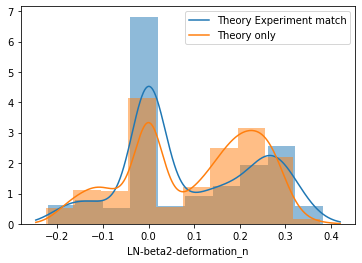

beta2-deformation_t overlap is: 0.9273597850350148


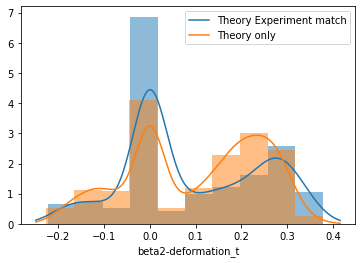

LN-beta2-deformation_t overlap is: 0.927438679681627


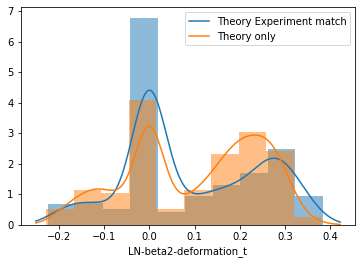

pairing-gap_n overlap is: 0.9316857516921837


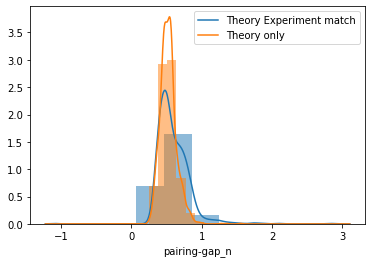

LN-beta2-deformation_p overlap is: 0.9388044663544316


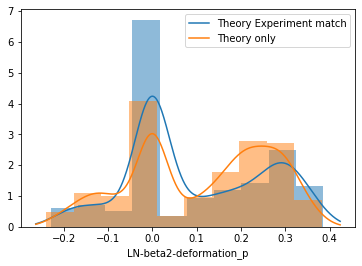

beta2-deformation_p overlap is: 0.9388232203753684


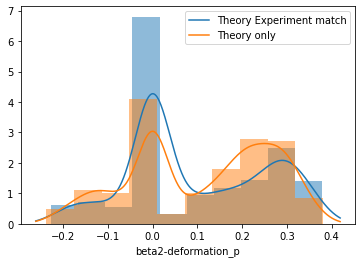

q8-moment_p overlap is: 0.9460610894594028


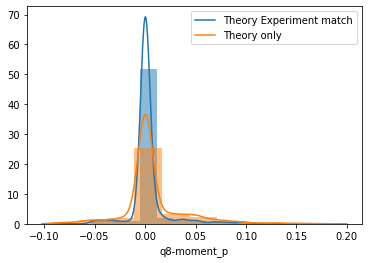

q6-moment_p overlap is: 0.9462454462544226


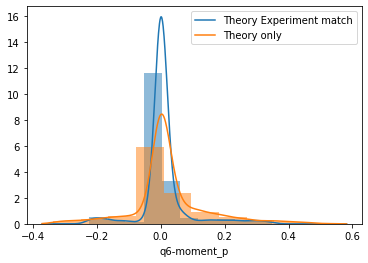

hexadecapole-moment_p overlap is: 0.951737809296979


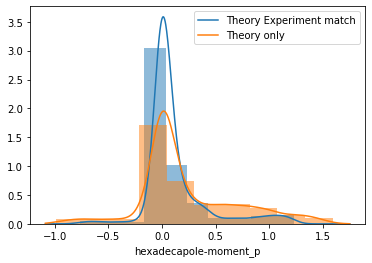

LN-hexadecapole-moment_p overlap is: 0.9525069506144447


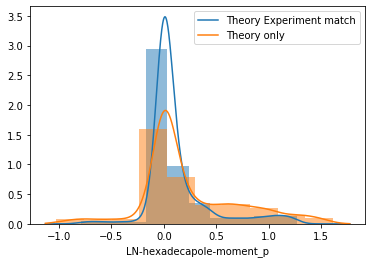

In [63]:
for j in top_overlap:
    #print("", i[1])
    
    for i in overlapped:
        #print("   ", j)
        if i[1]==j:
            print(i[0],"  ", i[1])
                
                    
                
            #print("\n\n")

for j in top_overlap:
    #print("", i[1])
    
    for i in overlapped:
        #print("   ", j)
        if i[1]==j:
            beta2_total_overlap = compare_two_properties(exp_match,theory_only,i[0],'Theory Experiment match','Theory only')



In [36]:
exp_match['quadrupole-moment_p']
'spin-orbit-energy'
'beta2-deformation_n' 
'LN-beta2-deformation_n'
'pairing-gap_n'
'beta2-deformation_p'

'beta2-deformation_p'

In [37]:
exp_match['quadrupole-moment_p']
#theory_only['quadrupole-moment_p']

0     -0.000014
1     -0.000079
2      0.000049
3     -0.000000
4     -0.002323
         ...   
854   -8.358051
855   -7.457371
856   -7.209352
857   -6.241304
858   -6.225589
Name: quadrupole-moment_p, Length: 859, dtype: float64

In [38]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 10000, random_state=42)


In [39]:
X = np.transpose(np.stack((exp_match['quadrupole-moment_p'],
                           exp_match['spin-orbit-energy'],
                           exp_match['beta2-deformation_p'])))
#exp_match['beta2-deformation_n'],
#                           exp_match['LN-beta2-deformation_n'],
#                           exp_match['pairing-gap_n'],
#                           exp_match['beta2-deformation_p'])))
y =exp_match_diff
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state=42 )


In [40]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [41]:
rf_prediction_train       =rf.predict(X_train)
rf_prediction_test        =rf.predict(X_test)
rf_prediction_train_test  =rf.predict(X)
exp_match["rf_predictions"]=rf_prediction_train_test

In [118]:
rf.score(X_test,y_test)

0.4449503874414866

In [119]:
rf.feature_importances_

array([0.29909584, 0.51051264, 0.19039151])

In [125]:
Ni_match   = exp_match.loc[exp_match["proton_number"]==28]
Ni_theory  = theory_only.loc[theory_only["proton_number"]==28]
   

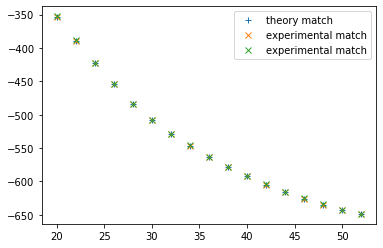

In [126]:
#plt.plot(Ni_theory['neutron_number'], Ni_theory['energy'], 'x', label='theory only')
plt.plot(Ni_match['neutron_number'], Ni_match['energy'], '+', label='theory match')
#plt.plot(Ni_match['neutron_number'], Ni_match['exp_energy'], 'x', label='experimental match')
plt.plot(Ni_match['neutron_number'], Ni_match['exp_energy']+Ni_match['exp_theory_diff'], 'x', label='experimental match')
plt.plot(Ni_match['neutron_number'], Ni_match['exp_energy']+Ni_match['rf_predictions'], 'x', label='rf_predictions match')

plt.legend()
plt.show()

In [127]:
mean_squared_error(Ni_match['exp_theory_diff'],Ni_match['rf_predictions'])

0.3995686184644691

In [96]:
Ni_theory#.columns


,neutron_number,proton_number,energy,converged,accuracy,chemical-pot_n,chemical-pot_p,Fermi-level_n,Fermi-level_p,pairing-gap_n,...,direct-coulomb,exchange-coulomb,pairing-coulomb,tensor-energy,direct-hartree,extra-energy,external-field-energy,entropy_n,entropy_p,entropy_t
215,18,28,-312.044867,True,0.000004,-21.707471,2.638724,-21.707471,2.638724,0.654437,...,142.423391,-10.664802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233,54,28,-653.577878,True,0.000002,-2.574493,-19.648325,-2.574493,-19.648325,0.566418,...,134.126827,-10.227568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234,56,28,-657.875398,True,0.000008,-2.124834,-20.332046,-2.124834,-20.332046,0.533906,...,133.688782,-10.186488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
235,58,28,-661.323457,True,0.000008,-1.655623,-20.923168,-1.655623,-20.923168,0.508325,...,133.216903,-10.145934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,60,28,-663.899948,True,0.000008,-1.183326,-21.454721,-1.183326,-21.454721,0.521270,...,132.661459,-10.102649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237,62,28,-665.441056,True,0.000007,-0.769986,-22.036091,-0.769986,-22.036091,0.586868,...,131.925681,-10.048420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238,64,28,-666.032537,True,0.000003,-0.425136,-22.684117,-0.425136,-22.684117,0.624511,...,131.033398,-9.983751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239,66,28,-666.014759,True,0.000007,-0.137235,-23.392439,-0.137235,-23.392439,0.654967,...,130.008125,-9.910281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240,68,28,-665.727372,True,0.000003,0.136599,-24.098323,0.136599,-24.098323,0.670830,...,128.996311,-9.838305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
241,70,28,-664.843499,True,0.000005,0.466609,-24.784198,0.466609,-24.784198,0.694238,...,128.111875,-9.776063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
for i in Ni_match.columns:
    print(i)

Num
Nuc
A
neutron_number
proton_number
exp_energy
exp_energy_per_nucleons
dE
Eval
S1n
dS1n
Eval.1
S1p
dS1p
Eval.2
S2n
dS2n
Eval.3
S2p
dS2p
Eval.4
energy
converged
accuracy
chemical-pot_n
chemical-pot_p
Fermi-level_n
Fermi-level_p
pairing-gap_n
pairing-gap_p
pairing-cutoff
pairing-energy_n
pairing-energy_p
pairing-energy_t
effective-strength-G_n
effective-strength-G_p
LN-chemical-pot_n
LN-chemical-pot_p
LN-energy_n
LN-energy_p
LN-energy_t
rms-radius_n
rms-radius_p
rms-radius_t
charge-radius
nuclear-radius
LN-rms-radius_n
LN-rms-radius_p
LN-rms-radius_t
LN-charge-radius
LN-nuclear-radius
beta2-deformation_n
beta2-deformation_p
beta2-deformation_t
LN-beta2-deformation_n
LN-beta2-deformation_p
LN-beta2-deformation_t
dipole-moment_n
dipole-moment_p
dipole-moment_t
quadrupole-moment_n
quadrupole-moment_p
quadrupole-moment_t
LN-quadrupole-moment_n
LN-quadrupole-moment_p
LN-quadrupole-moment_t
octupole-moment_n
octupole-moment_p
octupole-moment_t
hexadecapole-moment_n
hexadecapole-moment_p
hex